In [1]:
import scipy.io
import os
import numpy as np
from matplotlib import pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset

from sklearn.preprocessing import StandardScaler
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans

from tqdm import tqdm

In [27]:
torch.cuda_is_available()

AttributeError: module 'torch' has no attribute 'cuda_is_available'

In [3]:
from PIL import Image
import glob
import os
import numpy as np
from tqdm import tqdm

def load_images_from_folder(folder, size=(64, 64)):
    images = []
    for filename in glob.glob(f'{folder}/*.jpg'): # Adjust the path if needed
        with Image.open(filename) as img:
            img = img.resize(size)
            images.append(np.array(img))
    return np.array(images)

def load_dataset(base_path, n_objects=1655, n_images_per_object=10):
    all_images = []
    image_count_per_folder = []
    for i in tqdm(range(n_objects), desc="Loading Images"):
        folder_name = os.path.join(base_path, f'{i:05d}_*')  # Adjust the format as per your folder naming
        for folder in glob.glob(folder_name):
            images = load_images_from_folder(folder)
            all_images.extend(images)
            image_count_per_folder.append(len(images))
    return np.array(all_images), image_count_per_folder

# Load dataset and check image counts
dataset_path = "C:/Users/omara/Downloads/Things_training_images-20231205T194843Z-001/Things_training_images"
dataset, image_counts = load_dataset(dataset_path)

# Normalize the dataset
images = dataset / 255.0  # Normalize pixel values to [0, 1]

# Verify if each folder has exactly 10 images
all_folders_have_10_images = all(count == 10 for count in image_counts)
print(f"All folders have exactly 10 images: {all_folders_have_10_images}")


Loading Images: 100%|██████████| 1655/1655 [03:24<00:00,  8.08it/s]


All folders have exactly 10 images: True


In [4]:
# Find the index of folders that don't have exactly 10 images
incorrect_folders = [i for i, count in enumerate(image_counts) if count != 10]

# Print the indices
print(f"Folders with incorrect number of images: {incorrect_folders}")


Folders with incorrect number of images: []


In [6]:
import pickle

# The path where the pickled data will be saved
pickle_file_path = "C:/Users/omara/OneDrive/Desktop/cs236proje/images_dataset.pkl"

# Function to save the numpy array of images as a pickle file
def save_as_pickle(data, file_path):
    with open(file_path, 'wb') as file:
        pickle.dump(data, file)

# Save the images numpy array
save_as_pickle(images, pickle_file_path)

In [2]:
import pickle

# The path where the pickled data is stored
pickle_file_path = "C:/Users/omara/OneDrive/Desktop/cs236proje/images_dataset.pkl"

# Function to load the numpy array of images from a pickle file
def load_from_pickle(file_path):
    with open(file_path, 'rb') as file:
        data = pickle.load(file)
    return data

# Load the images numpy array
images = load_from_pickle(pickle_file_path)

# Check the shape of the loaded data if needed
print(images.shape)


(16540, 64, 64, 3)


In [3]:
def load_eeg_data(base_path, n_patients=10):
    eeg_data = {}
    for i in range(1, n_patients + 1):
        patient_id = f'sub{i:02d}'
        eeg_file_path = os.path.join(base_path, patient_id, 'preprocessed_eeg_training.npy')
        eeg_data[patient_id] = np.load(eeg_file_path, allow_pickle=True).item()
    return eeg_data

# Base path where the patient folders are located
base_path = "C:/Users/omara/Downloads"

# Load EEG data for all patients
eeg_dataset = load_eeg_data(base_path)
#keys are sub01, sub02, ..., sub10
#values are the eeg data for those paitents

In [4]:
#first patient data, what we were working w before
firstpatient = eeg_dataset['sub01']['preprocessed_eeg_data']
firstpatient.shape
firstpatient

array([[[[-8.04186913e-01, -3.99273945e-01,  7.78692699e-02, ...,
          -8.42950374e-01, -3.06535595e-01,  3.52179575e-02],
         [-7.82207319e-01, -4.03134310e-01, -1.15444878e-01, ...,
          -1.49925647e+00, -1.95196105e+00, -2.24008070e+00],
         [-1.66649827e+00, -1.66071042e+00, -1.61374430e+00, ...,
           9.68628867e-01,  3.34326054e-01, -4.64534184e-01],
         ...,
         [ 1.37716061e-01,  2.90468749e-01, -2.44187330e-01, ...,
           2.35354180e-01, -1.14948921e-01, -4.94730194e-01],
         [ 5.26930485e-01,  3.05160440e-01, -2.44914725e-01, ...,
          -2.99466113e-01, -2.39836505e-01, -6.34345740e-02],
         [-1.41619615e-01, -2.79937625e-02,  2.40542950e-01, ...,
           7.34310800e-02,  7.51322910e-02,  4.67900549e-01]],

        [[ 8.69914054e-01,  9.46604107e-01,  1.03396723e+00, ...,
          -8.35081815e-02,  4.59028504e-01,  8.99504379e-01],
         [ 5.71233072e-01,  4.65777696e-01,  5.06248930e-01, ...,
          -1.09205038e

In [5]:
secondpatient = eeg_dataset['sub02']['preprocessed_eeg_data']
secondpatient.shape

(16540, 4, 17, 100)

In [6]:
#we want one numpy array that represents all ten patients, with size (16540, 10, 4, 17, 100)
all_patients_data = np.zeros((16540, 10, 4, 17, 100))

# Iterate over each patient and store their data
for i in range(10):
    patient_id = f'sub{i+1:02d}'
    patient_data = eeg_dataset[patient_id]['preprocessed_eeg_data']
    # Assuming patient_data is already in the shape (number of samples, repetitions, channels, time points)
    all_patients_data[:, i] = patient_data

to access the first patient data: all_patients_data[:, 0]

In [14]:
# The path where the pickled data will be saved
pickle_file_path = "C:/Users/omara/OneDrive/Desktop/cs236proje/eeg_dataset.pkl"

# Function to save the numpy array of images as a pickle file
def save_as_pickle(data, file_path):
    with open(file_path, 'wb') as file:
        pickle.dump(data, file)

# Save the images numpy array
save_as_pickle(all_patients_data, pickle_file_path)

In [21]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class CVAE(nn.Module):
    def __init__(self, eeg_size, image_size, latent_dim, num_patients=10):
        super(CVAE, self).__init__()
        self.latent_dim = latent_dim
        self.num_patients = num_patients

        # Shared EEG encoder for all patients
        self.eeg_encoder = nn.Sequential(
            nn.Flatten(),
            nn.Linear(eeg_size, 128),
            nn.ReLU(),
            nn.Linear(128, latent_dim * 2)  # Outputting mean and log-variance
        )

        # Image encoder
        self.image_encoder = nn.Sequential(
            nn.Flatten(),
            nn.Linear(image_size, 128),
            nn.ReLU(),
            nn.Linear(128, latent_dim * 2)
        )

        # Decoder
        self.decoder = nn.Sequential(
            nn.Linear(latent_dim, 128),
            nn.ReLU(),
            nn.Linear(128, image_size),
            nn.Sigmoid()  # Assuming images are normalized between 0 and 1
        )

    def reparameterize(self, mu, log_var):
        std = torch.exp(0.5 * log_var)
        eps = torch.randn_like(std)
        return mu + eps * std

    def forward(self, eegs, image):
        # Process EEG data for each patient
        patient_latents = []
        for i in range(self.num_patients):
            # Select EEG data for the ith patient
            eeg_patient = eegs[:, i, :].view(eegs.size(0), -1)  # Reshape EEG data for each patient
            eeg_latent = self.eeg_encoder(eeg_patient)
            patient_latents.append(eeg_latent)

        # Combine EEG latents across patients
        eeg_latent = torch.stack(patient_latents).mean(dim=0)

        # Process image
        image_latent = self.image_encoder(image)

        # Split the result into mean and log-variance
        eeg_mu, eeg_log_var = torch.chunk(eeg_latent, 2, dim=1)
        image_mu, image_log_var = torch.chunk(image_latent, 2, dim=1)

        # Combine EEG and image information in latent space
        mu = (eeg_mu + image_mu) / 2
        log_var = (eeg_log_var + image_log_var) / 2

        z = self.reparameterize(mu, log_var)
        recon_image = self.decoder(z)

        # Reshape recon_image to have the same shape as the input images
        recon_image = recon_image.view(-1, 3, 64, 64)  # Reshape to [batch_size, channels, height, width]

        return recon_image, mu, log_var, eeg_mu, eeg_log_var


# Initialize the model
eeg_size = 4 * 17 * 100  # Adjust according to your EEG data shape
image_size = 64 * 64 * 3  # Adjust for your image size
latent_dim = 10  # You can experiment with this
cvae = CVAE(eeg_size, image_size, latent_dim)


In [22]:
def cvae_loss(recon_image, original_image, mu, log_var):
    # Reconstruction loss (MSE for simplicity)
    recon_loss = F.mse_loss(recon_image, original_image, reduction='sum')

    # KL divergence loss
    kl_loss = -0.5 * torch.sum(1 + log_var - mu.pow(2) - log_var.exp())

    return recon_loss + kl_loss


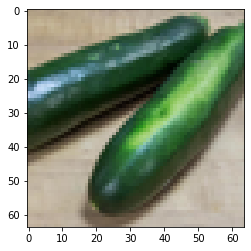

In [12]:
##SANITY CHECK: images50[0] SHOULD BE 0TH AARDVARK
from matplotlib import pyplot as plt
plt.imshow(images[16539], interpolation='nearest')
plt.show()

In [18]:
import torch
from torch.utils.data import TensorDataset, DataLoader

# Convert the EEG and image data to PyTorch tensors
eeg_data_tensor = torch.tensor(all_patients_data, dtype=torch.float32)
images_tensor = torch.tensor(images, dtype=torch.float32)  # Convert to NCHW format

# Create a dataset and data loader
dataset = TensorDataset(eeg_data_tensor, images_tensor)
dataloader = DataLoader(dataset, batch_size=32, shuffle=True)  # Adjust batch size as needed


EEG data tensor shape: torch.Size([16540, 6800])
Image tensor shape: torch.Size([16540, 12288])


In [19]:
eeg_data_tensor.shape

torch.Size([16540, 6800])

In [23]:
from torch.optim import Adam

# Check for GPU availability
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Move the model to GPU (if available)
cvae = cvae.to(device)

optimizer = Adam(cvae.parameters(), lr=0.001)

# Training loop
num_epochs = 10  # Adjust as needed
for epoch in range(num_epochs):
    cvae.train()
    train_loss = 0
    for eeg, image in dataloader:
        # Move data to GPU
        eeg = eeg.to(device)
        image = image.to(device)

        # Reshape EEG data to match the batch size and number of patients
        eeg = eeg.view(eeg.size(0), -1, 4 * 17 * 100)  # Reshape to [batch_size, num_patients, eeg_size]

        optimizer.zero_grad()

        # Forward pass
        recon_image, mu, log_var, _, _ = cvae(eeg, image)

        # Loss calculation
        loss = cvae_loss(recon_image, image, mu, log_var)

        # Backward pass and optimize
        loss.backward()
        optimizer.step()

        train_loss += loss.item()

    # Logging
    average_loss = train_loss / len(dataloader.dataset)
    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {average_loss:.4f}")


Using device: cpu
Epoch [1/10], Loss: 566.6594
Epoch [2/10], Loss: 299930548.5994
Epoch [3/10], Loss: 216529535661913.1250
Epoch [4/10], Loss: nan
Epoch [5/10], Loss: nan
Epoch [6/10], Loss: nan
Epoch [7/10], Loss: nan
Epoch [8/10], Loss: nan
Epoch [9/10], Loss: nan
Epoch [10/10], Loss: nan


In [25]:
import matplotlib.pyplot as plt
import torch

# Select the subset of EEG data for visualization
eeg_subset = eeg_data_tensor[0:10]  # Selecting the first 10 samples

# Since the model expects batched data, ensure the dimensions are correct
eeg_subset = eeg_subset.view(-1, 10, 4 * 17 * 100)  # Reshape if necessary

# Generate images with the model
# Note: We need to provide some image input as well, even though it's not used in generation
# You can use a tensor of zeros or any dummy tensor with the correct shape
dummy_image_input = torch.zeros(10, 3, 64, 64)  # Dummy image input
with torch.no_grad():
    cvae.eval()  # Set the model to evaluation mode
    generated_images, _, _, _, _ = cvae(eeg_subset, dummy_image_input)

# Reshape the generated images to make them plottable (if they are not already in the correct shape)
generated_images = generated_images.view(10, 3, 64, 64)

# Plot the generated images
fig, axes = plt.subplots(1, 10, figsize=(20, 2))
for i, ax in enumerate(axes):
    ax.imshow(generated_images[i].permute(1, 2, 0).cpu().numpy())  # Convert to numpy array and permute dimensions for plotting
    ax.axis('off')
plt.show()

RuntimeError: mat1 and mat2 shapes cannot be multiplied (1x68000 and 6800x128)

In [16]:
print(all_patients_data.shape)
print(images.shape)

(16540, 10, 4, 17, 100)
(16540, 64, 64, 3)
